In [1]:
import matplotlib.pyplot as plt
from utils.utils_dataset import convert_to_color, convert_from_color, erode_gt, conn_comp
from datasets.dataset import *
from utils.utils import *
from net.unet import UNet
from skimage.morphology import disk
from skimage import io
from net.train import train
from net.test_network import test
from model.extract_activations import extract_activation
from utils.utils_quadtree import make_squares_from_patches, create_quad_tree
from utils.export_result import *
from model.ensemble_estimation import ensemble_estim
from model.mpmOnQuadtree.method import *
from pathlib import Path 

# Torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torch.optim.lr_scheduler
import torch.nn.init
from torch.autograd import Variable

In [2]:
input_folder = Path('input/')
output_folder = Path('output/')

## Data

### Parameters

Definition of the parameters used to deal with the [ISPRS 2D Semantic Labeling Challenge datasets](https://www2.isprs.org/commissions/comm2/wg4/benchmark/semantic-labeling/).

In [3]:
# Parameters
window_size = (256, 256) # Patch size
stride = 32 # Stride for testing
in_channels = 3 # Number of input channels (e.g. RGB)
FOLDER = input_folder
batch_size = 10 # Number of samples in a mini-batch

labels = ["roads", "buildings", "low veg.", "trees", "cars", "clutter"] # Label names
n_classes = len(labels) # Number of classes
weights = torch.ones(n_classes) # Weights for class balancing
CACHE = True # Store the dataset in-memory


DATASET = 'Vaihingen'

if DATASET == 'Potsdam':
    MAIN_FOLDER = FOLDER + 'Potsdam/'
    DATA_FOLDER = MAIN_FOLDER + '3_Ortho_IRRG/top_potsdam_{}_IRRG.tif'
    LABEL_FOLDER = MAIN_FOLDER + '5_Labels_for_participants/top_potsdam_{}_label.tif'
    ERODED_FOLDER = MAIN_FOLDER + '5_Labels_for_participants_no_Boundary/top_potsdam_{}_label_noBoundary.tif' 
    DSM_FOLDER = MAIN_FOLDER + '1_DSM/dsm_potsdam_0{}.tif'
    NDSM_FOLDER = MAIN_FOLDER + '1_DSM_normalisation/dsm_potsdam_0{}_normalized_lastools.jpg'

elif DATASET == 'Vaihingen':
    MAIN_FOLDER = FOLDER + 'Vaihingen/'
    DATA_FOLDER = MAIN_FOLDER + 'ISPRS_semantic_labeling_Vaihingen/top/top_mosaic_09cm_area{}.tif'
    LABEL_FOLDER = MAIN_FOLDER + 'ISPRS_semantic_labeling_Vaihingen/gts_for_participants/top_mosaic_09cm_area{}.tif'
    ERODED_FOLDER = MAIN_FOLDER + 'ISPRS_semantic_labeing_Vaihingen_ground_truth_eroded_for_participants/top_mosaic_09cm_area{}_noBoundary.tif'

### Display of the dataset

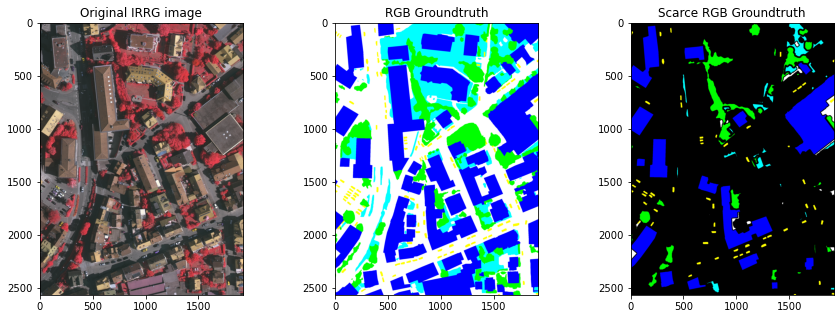

In [4]:
# Displaying one IRRG image, its GT and the scarce GT
fig = plt.figure(figsize=(15, 5))
img = io.imread(MAIN_FOLDER + 'ISPRS_semantic_labeling_Vaihingen/top/top_mosaic_09cm_area1.tif')
fig.add_subplot(131)
plt.imshow(img)
plt.title("Original IRRG image")
gt = io.imread(MAIN_FOLDER + 'ISPRS_semantic_labeling_Vaihingen/gts_for_participants/top_mosaic_09cm_area1.tif')
fig.add_subplot(132)
plt.imshow(gt)
plt.title("RGB Groundtruth")
gt_s = convert_to_color(conn_comp(convert_from_color(gt), disk(8)), palette)
fig.add_subplot(133)
plt.imshow(gt_s)
plt.title("Scarce RGB Groundtruth")
plt.show()

### Loading the dataset

In [5]:
# Type of GT considered
# gt_type = 'ero' -> gt = erode_gt(gt, gt_modification); gt_modification : dimension of the kernel for the erosion
# gt_type = 'conncomp' -> gt = conn_comp(gt, gt_modification); gt_modification : dimension of the kernel for the erosion

# train/test split:
if DATASET == 'Vaihingen':
    train_ids = ['1', '3', '23', '26', '7', '11', '13', '28', '17', '32', '34', '37']
    test_ids = ['5', '21', '15', '30'] 
    train_set = ISPRS_dataset(train_ids, ids_type='TRAIN', gt_type = 'conncomp', gt_modification = disk(8), data_files=DATA_FOLDER,
                              label_files=LABEL_FOLDER, window_size=window_size, cache=CACHE)
    test_set = ISPRS_dataset(test_ids, ids_type='TEST',gt_type = 'conncomp', gt_modification = disk(8), data_files=DATA_FOLDER,
                             label_files=LABEL_FOLDER, window_size=window_size, cache=CACHE)

elif DATASET == 'Potsdam':
    train_ids = ['3_11', '4_11', '5_10', '6_7', '6_8', '6_9', '6_11', '7_7', '7_8', '7_9', '7_10', '7_12']
    train_dsm_ids = ['3_11', '4_11', '5_10', '6_07', '6_08', '6_09', '6_11', '7_07', '7_08', '7_09', '7_10', '7_12']
    test_ids = ['3_12', '4_10', '4_12', '5_11', '6_12']
    test_dsm_ids = ['3_12', '4_10', '4_12', '5_11', '6_12']
    train_set = ISPRS_dataset(train_ids, train_dsm_ids, ids_type='TRAIN', cache=CACHE)
    test_set = ISPRS_dataset(test_ids, test_dsm_ids, ids_type='TEST',cache=CACHE)


print("Tiles for training : ", train_ids)
print("Tiles for testing : ", test_ids)

train_loader = torch.utils.data.DataLoader(train_set,batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=batch_size)

Tiles for training :  ['1', '3', '23', '26', '7', '11', '13', '28', '17', '32', '34', '37']
Tiles for testing :  ['5', '21', '15', '30']


## Neural architecture

### Instantiate the FCN

In [6]:
# Any FCN can work with the proposed method
# In this case we employ a U-Net
net = UNet(n_channels=in_channels, n_classes=n_classes, bilinear=True) 

In [7]:
# download and load the pre-trained weights from VGG-16 on ImageNet

import os
try:
    from urllib.request import URLopener
except ImportError:
    from urllib import URLopener

# Download VGG-16 weights from PyTorch
vgg_url = 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth'
if not os.path.isfile('./vgg16_bn-6c64b313.pth'):
    weights = URLopener().retrieve(vgg_url, './vgg16_bn-6c64b313.pth')

vgg16_weights = torch.load('./vgg16_bn-6c64b313.pth')
mapped_weights = {}
for k_vgg, k_unet in zip(vgg16_weights.keys(), net.state_dict().keys()):
    if "features" in k_vgg:
        mapped_weights[k_unet] = vgg16_weights[k_vgg]
        print("Mapping {} to {}".format(k_vgg, k_unet))
        
try:
    net.load_state_dict(mapped_weights)
    print("Loaded VGG-16 weights in UNet !")
except:
    # Ignore missing keys
    pass

Mapping features.0.weight to inc.double_conv.0.weight
Mapping features.0.bias to inc.double_conv.0.bias
Mapping features.1.weight to inc.double_conv.1.weight
Mapping features.1.bias to inc.double_conv.1.bias
Mapping features.1.running_mean to inc.double_conv.1.running_mean
Mapping features.1.running_var to inc.double_conv.1.running_var
Mapping features.3.weight to inc.double_conv.1.num_batches_tracked
Mapping features.3.bias to inc.double_conv.3.weight
Mapping features.4.weight to inc.double_conv.3.bias
Mapping features.4.bias to inc.double_conv.4.weight
Mapping features.4.running_mean to inc.double_conv.4.bias
Mapping features.4.running_var to inc.double_conv.4.running_mean
Mapping features.7.weight to inc.double_conv.4.running_var
Mapping features.7.bias to inc.double_conv.4.num_batches_tracked
Mapping features.8.weight to down1.maxpool_conv.1.double_conv.0.weight
Mapping features.8.bias to down1.maxpool_conv.1.double_conv.0.bias
Mapping features.8.running_mean to down1.maxpool_conv.

In [8]:
net.cuda()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

### Optimizer

In [9]:
base_lr = 0.01
params_dict = dict(net.named_parameters())
params = []
for key, value in params_dict.items():
    if '_D' in key:
        # Decoder weights are trained at the nominal learning rate
        params += [{'params':[value],'lr': base_lr}]
    else:
        # Encoder weights are trained at lr / 2 (we have VGG-16 weights as initialization)
        params += [{'params':[value],'lr': base_lr / 2}]

optimizer = optim.SGD(net.parameters(), lr=base_lr, momentum=0.9, weight_decay=0.0005)
# We define the scheduler
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [25, 35, 45], gamma=0.1)

### Train of the network

In [ ]:
# training parameters
epochs = 30
save_epoch = 10

train(net, optimizer, epochs, save_epoch, weights, train_loader, batch_size=1, window_size=window_size, scheduler=None)

### Test the network

In [10]:
#net.load_state_dict(torch.load('/content/gdrive/My Drive/pytorch_run/segnet_final'))
net.load_state_dict(torch.load(output_folder / 'model'))

<All keys matched successfully>

In [ ]:
# Use the network on the test set
test_images = (1 / 255 * np.asarray(io.imread(DATA_FOLDER.format(id)), dtype='float32') for id in test_ids)
test_labels = (np.asarray(io.imread(LABEL_FOLDER.format(id)), dtype='uint8') for id in test_ids)
eroded_labels = (convert_from_color(io.imread(ERODED_FOLDER.format(id))) for id in test_ids)

acc_test, all_preds, all_gts = test(net, test_ids, test_images, test_labels, eroded_labels, labels, stride, batch_size, window_size, all=True)

## Building the quadtrees for the hierarchical PGM

### Training activations

In [11]:
train_image = (1 / 255 * np.asarray(io.imread(DATA_FOLDER.format(id)), dtype='float32') for id in [train_ids[1]])
train_label = (np.asarray(io.imread(LABEL_FOLDER.format(id)), dtype='uint8') for id in [train_ids[1]])  

In [12]:
train_activations, train_labels = extract_activation(net, train_image, train_label, num_patch=16, window_size=window_size)

C:\Users\marti\OneDrive - unige.it\Documents\PhD\Projects\U-Net_MPM_script\model\extract_activations.py:42: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image_patches = Variable(torch.from_numpy(image_ptc).cuda(), volatile=True)


[0. 1. 2. 3. 4. 6.]


### Test activations

In [13]:
test_image = (1 / 255 * np.asarray(io.imread(DATA_FOLDER.format(id)), dtype='float32') for id in [test_ids[0]])
test_label = (np.asarray(io.imread(LABEL_FOLDER.format(id)), dtype='uint8') for id in [test_ids[0]])  

In [14]:
test_activations, test_labels = extract_activation(net, test_image, test_label, num_patch=16, window_size=window_size)

[0. 1. 2. 3. 4. 6.]


### Visualization of the quadtrees

In [15]:
train_activations = make_squares_from_patches(train_activations, num_patch=16, window_size=window_size)
train_labels = make_squares_from_patches(train_labels, num_patch=16, window_size=window_size)
test_activations = make_squares_from_patches(test_activations, num_patch=16, window_size=window_size)
test_labels = make_squares_from_patches(test_labels, num_patch=16, window_size=window_size)

In [16]:
testImgQuadTree, testQuadTree = create_quad_tree(test_activations, test_labels)
imgQuadTree, mapQuadTree = create_quad_tree(train_activations, train_labels)

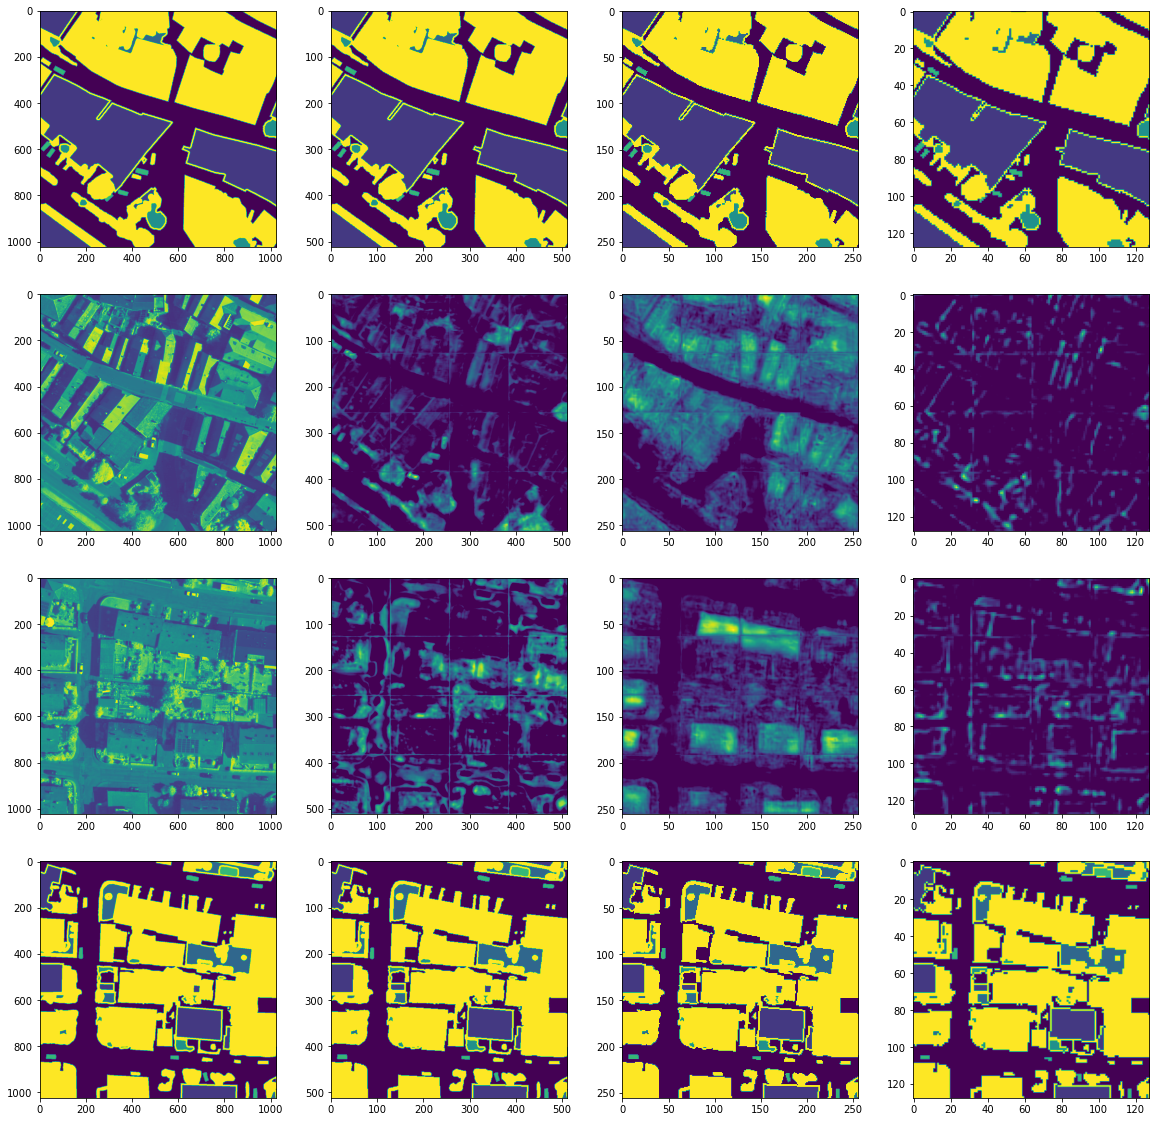

In [17]:
plt.figure(figsize=(20,20))
plt.subplot(4,4,1)
plt.imshow(testQuadTree[0][:,:,0])
plt.subplot(4,4,2)
plt.imshow(testQuadTree[1][:,:,0])
plt.subplot(4,4,3)
plt.imshow(testQuadTree[2][:,:,0])
plt.subplot(4,4,4)
plt.imshow(testQuadTree[3][:,:,0])
plt.subplot(4,4,5)
plt.imshow(testImgQuadTree[0][:,:,0])
plt.subplot(4,4,6)
plt.imshow(testImgQuadTree[1][:,:,0])
plt.subplot(4,4,7)
plt.imshow(testImgQuadTree[2][:,:,0])
plt.subplot(4,4,8)
plt.imshow(testImgQuadTree[3][:,:,0])
plt.subplot(4,4,9)
plt.imshow(imgQuadTree[0][:,:,0])
plt.subplot(4,4,10)
plt.imshow(imgQuadTree[1][:,:,3])
plt.subplot(4,4,11)
plt.imshow(imgQuadTree[2][:,:,0])
plt.subplot(4,4,12)
plt.imshow(imgQuadTree[3][:,:,0])
plt.subplot(4,4,13)
plt.imshow(mapQuadTree[0][:, :, 0])
plt.subplot(4,4,14)
plt.imshow(mapQuadTree[1][:,:,0])
plt.subplot(4,4,15)
plt.imshow(mapQuadTree[2][:,:,0])
plt.subplot(4,4,16)
plt.imshow(mapQuadTree[3][:,:,0])
plt.show()

## Experiment

In [18]:
# --- STARTING THE EXPERIMENT
# experiment_name identify which experiment to run.
# (must match the .json file in the experiments folder)
experiment_name = 'unet_mpm_vaihi'
# experiment and dataset are dictionaries imported from the json files with all the variables to run the program
experiment, dataset = initialize_experiment(experiment_name)
# R -> num of resolutions
# W -> width of the biggest image
# H -> height of the biggest image
# C -> num od classes
# _method -> method to estimate the statistics
R, W, H, C, _method, net_type = get_variables(experiment, dataset)
# outputs are placed in a folder named experiment_name in the output folder
output_path = set_output_location(experiment_name, output_folder, net_type)

>>>Starting the experiment:  unet_mpm_vaihi


In [19]:
output_path

WindowsPath('output/unet_mpm_vaihi')

### RF estimation

In [20]:
# training of the ensemble learning algorithm
predicted_labels, site_statistics = ensemble_estim(imgQuadTree, mapQuadTree, output_path, train=True)  # out format [r][c][h][w]

# test results of the ensemble learning algorithm
test_predicted_labels, test_site_statistics = ensemble_estim(testImgQuadTree, testQuadTree, output_path, train=False)


train samples
516499



train samples
129120



train samples
32277



train samples
8092
Random forest estimation started
Training the model
Predicting...
Random forest estimation started
Training the model
Predicting...
Random forest estimation started
Training the model
Predicting...
Random forest estimation started
Training the model
Predicting...



train samples
565357



train samples
141302



train samples
35291



train samples
8834
Random forest estimation started
Predicting...
Random forest estimation started
Predicting...
Random forest estimation started
Predicting...
Random forest estimation started
Predicting...


In [21]:
img_name = "res_RF_"
test_out_img = img_from_data(test_predicted_labels, H, W, R, output_path, img_name, _from='label', export=True)

storing image in -> " output\unet_mpm_vaihi\res_RF__r_0.raw "
storing image in -> " output\unet_mpm_vaihi\res_RF__r_1.raw "
storing image in -> " output\unet_mpm_vaihi\res_RF__r_2.raw "
storing image in -> " output\unet_mpm_vaihi\res_RF__r_3.raw "


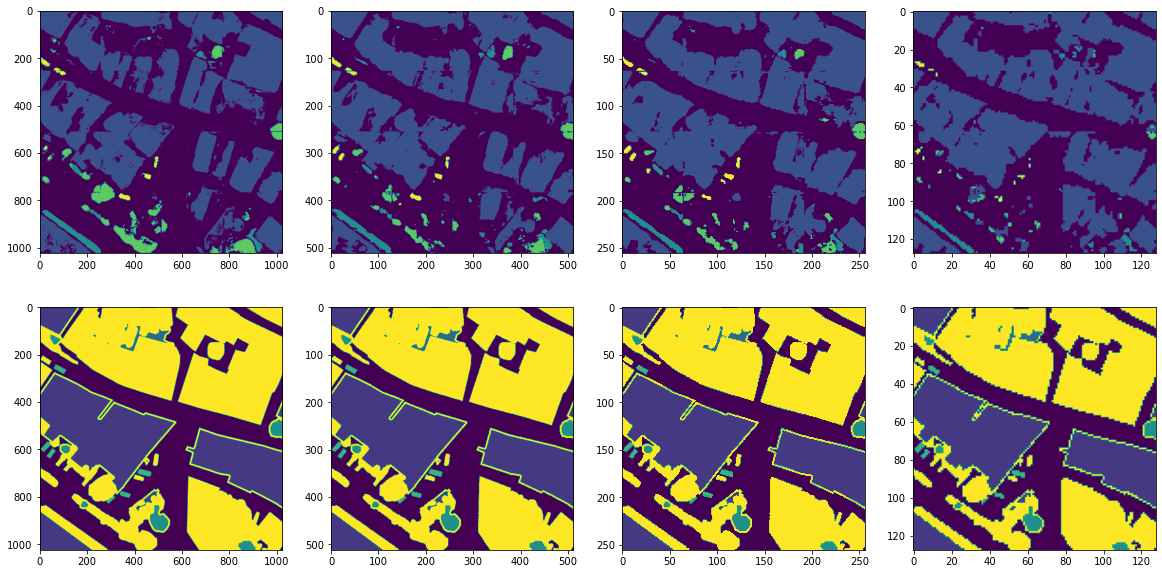

In [22]:
plt.figure(figsize=(20,10))
plt.subplot(241)
plt.imshow(np.transpose(test_out_img[0], [1,2,0])[:,:,0])
plt.subplot(242)
plt.imshow(np.transpose(test_out_img[1], [1,2,0])[:,:,0])
plt.subplot(243)
plt.imshow(np.transpose(test_out_img[2], [1,2,0])[:,:,0])
plt.subplot(244)
plt.imshow(np.transpose(test_out_img[3], [1,2,0])[:,:,0])
plt.subplot(245)
plt.imshow(testQuadTree[0][:,:,0])
plt.subplot(246)
plt.imshow(testQuadTree[1][:,:,0])
plt.subplot(247)
plt.imshow(testQuadTree[2][:,:,0])
plt.subplot(248)
plt.imshow(testQuadTree[3][:,:,0])
plt.show()

### MPM

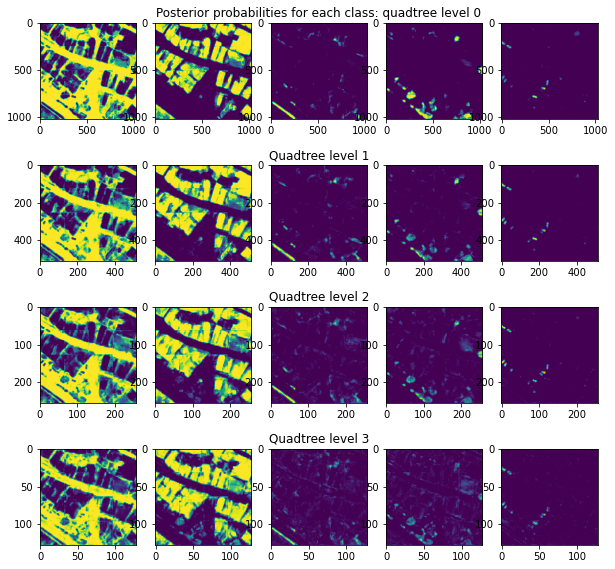

In [23]:
plt.figure(figsize=(10,10))
plt.subplot(4,5,1)
plt.imshow(test_site_statistics[0][0][:,:,0])
plt.subplot(4,5,2)
plt.imshow(test_site_statistics[0][1][:,:,0])
plt.subplot(4,5,3)
plt.title("Posterior probabilities for each class: quadtree level 0")
plt.imshow(test_site_statistics[0][2][:,:,0])
plt.subplot(4,5,4)
plt.imshow(test_site_statistics[0][3][:,:,0])
plt.subplot(4,5,5)
plt.imshow(test_site_statistics[0][4][:,:,0])
plt.subplot(4,5,6)
plt.imshow(test_site_statistics[1][0][:,:,0])
plt.subplot(4,5,7)
plt.imshow(test_site_statistics[1][1][:,:,0])
plt.subplot(4,5,8)
plt.title("Quadtree level 1")
plt.imshow(test_site_statistics[1][2][:,:,0])
plt.subplot(4,5,9)
plt.imshow(test_site_statistics[1][3][:,:,0])
plt.subplot(4,5,10)
plt.imshow(test_site_statistics[1][4][:,:,0])
plt.subplot(4,5,11)
plt.imshow(test_site_statistics[2][0][:,:,0])
plt.subplot(4,5,12)
plt.imshow(test_site_statistics[2][1][:,:,0])
plt.subplot(4,5,13)
plt.title("Quadtree level 2")
plt.imshow(test_site_statistics[2][2][:,:,0])
plt.subplot(4,5,14)
plt.imshow(test_site_statistics[2][3][:,:,0])
plt.subplot(4,5,15)
plt.imshow(test_site_statistics[2][4][:,:,0])
plt.subplot(4,5,16)
plt.imshow(test_site_statistics[3][0][:,:,0])
plt.subplot(4,5,17)
plt.imshow(test_site_statistics[3][1][:,:,0])
plt.subplot(4,5,18)
plt.title("Quadtree level 3")
plt.imshow(test_site_statistics[3][2][:,:,0])
plt.subplot(4,5,19)
plt.imshow(test_site_statistics[3][3][:,:,0])
plt.subplot(4,5,20)
plt.imshow(test_site_statistics[3][4][:,:,0])
plt.savefig(output_path / '_post_prob.png')

In [24]:
# ---- DATA FUSION ----

print('set transition probabilities')
    
resolutionTranProb = computeTransProb(C, experiment["method"]["theta"])
spatialTranProb = computeTransProb(C, experiment["method"]["phi"])


# prior is a list of arrays containing the prior probabilities for each layer
print('compute prior')
prior = computePrior(testQuadTree, R, C, resolutionTranProb)

# ---get transition contributions (from father, from neighbourhood)
# obs: delta_{ijkh} that appears in eq.(6) icip. with neighbour set composed by left and upper site
print('compute transition contributions')
transitionContrib = get_trans_contrib(R, C, resolutionTranProb, spatialTranProb, prior, num_neighbours=2)
transitionContribSingle = get_trans_contrib(R, C, resolutionTranProb, spatialTranProb, prior,
                                                    num_neighbours=1)

set transition probabilities
compute prior
len(prior) -> 3
len(prior) -> 4
compute transition contributions


In [25]:
partial_folder, _file = create_partial_post_folder(experiment, dataset, output_path, _method)

In [26]:
# --- BOTTOM-UP-PASS
# do it if it has never been done or if it is forced to be recomputed
if not os.path.isfile(_file):
    print('BOTTOM-UP-PASS started')
    # partialPost is p(xs|y_d(s)), where y_d(s) the observations of the descendants
    partialPost = bottom_up(test_site_statistics, resolutionTranProb, prior, R, C, H, W, _method)

    # save partialPost in file
    # storeTensor(partialPost, 'data/output/'+str(mainName)+'/partialPost/partialPost.raw', 8)
    print('saving partialPost at root')
    # check if directory for output exist, if not creates it
    pathlib.Path(partial_folder).mkdir(parents=True, exist_ok=True)
    _tmp_file = partial_folder / str(str(_method) + '_bott-up')
    np.save(_tmp_file, partialPost)

BOTTOM-UP-PASS started
0 layer: compute partialPost
0 layer: compute gamma term
1  layer: compute partialPost
1  layer: compute gamma term
2  layer: compute partialPost
2  layer: compute gamma term
3  layer: compute partialPost
3  layer: compute gamma term
saving partialPost at root


In [27]:
# partial posts are available
print('loading partialPost from file')
partialPost = np.load(_file)
start_time = time.time()
print(partialPost.shape)

loading partialPost from file
(4, 5, 1024, 1024)


In [28]:
# --- TOP-DOWN-PASS
print('TOP-DOWN-PASS started')
partialPost = top_down(R, H, W, experiment, partialPost, transitionContrib, transitionContribSingle,
                            partial_folder)

TOP-DOWN-PASS started


--R-- -> -- 2 --
---->  256
---->  256
0 %
1 %
2 %
3 %
4 %
5 %
6 %
7 %
8 %
9 %
10 %
10 %
11 %
12 %
13 %
14 %
15 %
16 %
17 %
18 %
19 %
20 %
21 %
21 %
22 %
23 %
24 %
25 %
26 %
27 %
28 %
29 %
30 %
31 %
32 %
32 %
33 %
34 %
35 %
36 %
37 %
38 %
39 %
40 %
41 %
42 %
43 %
43 %
44 %
45 %
46 %
47 %
48 %
49 %
50 %
51 %
52 %
53 %
54 %
54 %
55 %
56 %
57 %
58 %
59 %
60 %
61 %
62 %
63 %
64 %
65 %
65 %
66 %
67 %
68 %
69 %
70 %
71 %
72 %
73 %
74 %
75 %
75 %
76 %
77 %
78 %
79 %
80 %
81 %
82 %
83 %
84 %
85 %
86 %
86 %
87 %
88 %
89 %
90 %
91 %
92 %
93 %
94 %
95 %
96 %
97 %
97 %
98 %
99 %
0 %
1 %
2 %
3 %
4 %
5 %
6 %
7 %
8 %
9 %
10 %
10 %
11 %
12 %
13 %
14 %
15 %
16 %
17 %
18 %
19 %
20 %
21 %
21 %
22 %
23 %
24 %
25 %
26 %
27 %
28 %
29 %
30 %
31 %
32 %
32 %
33 %
34 %
35 %
36 %
37 %
38 %
39 %
40 %
41 %
42 %
43 %
43 %
44 %
45 %
46 %
47 %
48 %
49 %
50 %
51 %
52 %
53 %
54 %
54 %
55 %
56 %
57 %
58 %
59 %
60 %
61 %
62 %
63 %
64 %
65 %
65 %
66 %
67 %
68 %
69 %
70 %
71 %
72 %
73 %
74 %
75 %
75 %
76 %
77 %
78 %
79 %
8

47 %
47 %
48 %
48 %
48 %
48 %
49 %
49 %
49 %
49 %
50 %
50 %
50 %
51 %
51 %
51 %
51 %
52 %
52 %
52 %
52 %
53 %
53 %
53 %
53 %
54 %
54 %
54 %
55 %
55 %
55 %
55 %
56 %
56 %
56 %
56 %
57 %
57 %
57 %
57 %
58 %
58 %
58 %
59 %
59 %
59 %
59 %
60 %
60 %
60 %
60 %
61 %
61 %
61 %
61 %
62 %
62 %
62 %
63 %
63 %
63 %
63 %
64 %
64 %
64 %
64 %
65 %
65 %
65 %
65 %
66 %
66 %
66 %
67 %
67 %
67 %
67 %
68 %
68 %
68 %
68 %
69 %
69 %
69 %
69 %
70 %
70 %
70 %
71 %
71 %
71 %
71 %
72 %
72 %
72 %
72 %
73 %
73 %
73 %
73 %
74 %
74 %
74 %
75 %
75 %
75 %
75 %
76 %
76 %
76 %
76 %
77 %
77 %
77 %
77 %
78 %
78 %
78 %
79 %
79 %
79 %
79 %
80 %
80 %
80 %
80 %
81 %
81 %
81 %
81 %
82 %
82 %
82 %
83 %
83 %
83 %
83 %
84 %
84 %
84 %
84 %
85 %
85 %
85 %
85 %
86 %
86 %
86 %
87 %
87 %
87 %
87 %
88 %
88 %
88 %
88 %
89 %
89 %
89 %
89 %
90 %
90 %
90 %
91 %
91 %
91 %
91 %
92 %
92 %
92 %
92 %
93 %
93 %
93 %
93 %
94 %
94 %
94 %
95 %
95 %
95 %
95 %
96 %
96 %
96 %
96 %
97 %
97 %
97 %
97 %
98 %
98 %
98 %
99 %
99 %
99 %
second zigzag
0 %
0 

20 %
20 %
20 %
20 %
20 %
20 %
20 %
20 %
20 %
20 %
20 %
20 %
20 %
21 %
21 %
21 %
21 %
21 %
21 %
21 %
21 %
21 %
21 %
21 %
21 %
21 %
21 %
21 %
21 %
21 %
22 %
22 %
22 %
22 %
22 %
22 %
22 %
22 %
22 %
22 %
22 %
22 %
22 %
22 %
22 %
22 %
22 %
23 %
23 %
23 %
23 %
23 %
23 %
23 %
23 %
23 %
23 %
23 %
23 %
23 %
23 %
23 %
23 %
23 %
23 %
24 %
24 %
24 %
24 %
24 %
24 %
24 %
24 %
24 %
24 %
24 %
24 %
24 %
24 %
24 %
24 %
24 %
25 %
25 %
25 %
25 %
25 %
25 %
25 %
25 %
25 %
25 %
25 %
25 %
25 %
25 %
25 %
25 %
25 %
25 %
26 %
26 %
26 %
26 %
26 %
26 %
26 %
26 %
26 %
26 %
26 %
26 %
26 %
26 %
26 %
26 %
26 %
27 %
27 %
27 %
27 %
27 %
27 %
27 %
27 %
27 %
27 %
27 %
27 %
27 %
27 %
27 %
27 %
27 %
27 %
28 %
28 %
28 %
28 %
28 %
28 %
28 %
28 %
28 %
28 %
28 %
28 %
28 %
28 %
28 %
28 %
28 %
29 %
29 %
29 %
29 %
29 %
29 %
29 %
29 %
29 %
29 %
29 %
29 %
29 %
29 %
29 %
29 %
29 %
29 %
30 %
30 %
30 %
30 %
30 %
30 %
30 %
30 %
30 %
30 %
30 %
30 %
30 %
30 %
30 %
30 %
30 %
31 %
31 %
31 %
31 %
31 %
31 %
31 %
31 %
31 %
31 %
31 %
31 %
31 %


16 %
16 %
16 %
16 %
16 %
16 %
16 %
16 %
16 %
16 %
16 %
16 %
16 %
16 %
16 %
17 %
17 %
17 %
17 %
17 %
17 %
17 %
17 %
17 %
17 %
17 %
17 %
17 %
17 %
17 %
17 %
17 %
18 %
18 %
18 %
18 %
18 %
18 %
18 %
18 %
18 %
18 %
18 %
18 %
18 %
18 %
18 %
18 %
18 %
18 %
19 %
19 %
19 %
19 %
19 %
19 %
19 %
19 %
19 %
19 %
19 %
19 %
19 %
19 %
19 %
19 %
19 %
20 %
20 %
20 %
20 %
20 %
20 %
20 %
20 %
20 %
20 %
20 %
20 %
20 %
20 %
20 %
20 %
20 %
20 %
21 %
21 %
21 %
21 %
21 %
21 %
21 %
21 %
21 %
21 %
21 %
21 %
21 %
21 %
21 %
21 %
21 %
22 %
22 %
22 %
22 %
22 %
22 %
22 %
22 %
22 %
22 %
22 %
22 %
22 %
22 %
22 %
22 %
22 %
23 %
23 %
23 %
23 %
23 %
23 %
23 %
23 %
23 %
23 %
23 %
23 %
23 %
23 %
23 %
23 %
23 %
23 %
24 %
24 %
24 %
24 %
24 %
24 %
24 %
24 %
24 %
24 %
24 %
24 %
24 %
24 %
24 %
24 %
24 %
25 %
25 %
25 %
25 %
25 %
25 %
25 %
25 %
25 %
25 %
25 %
25 %
25 %
25 %
25 %
25 %
25 %
25 %
26 %
26 %
26 %
26 %
26 %
26 %
26 %
26 %
26 %
26 %
26 %
26 %
26 %
26 %
26 %
26 %
26 %
27 %
27 %
27 %
27 %
27 %
27 %
27 %
27 %
27 %
27 %
27 %


13 %
13 %
13 %
13 %
13 %
13 %
13 %
13 %
14 %
14 %
14 %
14 %
14 %
14 %
14 %
14 %
14 %
14 %
14 %
14 %
14 %
14 %
14 %
15 %
15 %
15 %
15 %
15 %
15 %
15 %
15 %
15 %
15 %
15 %
15 %
15 %
15 %
15 %
16 %
16 %
16 %
16 %
16 %
16 %
16 %
16 %
16 %
16 %
16 %
16 %
16 %
16 %
16 %
17 %
17 %
17 %
17 %
17 %
17 %
17 %
17 %
17 %
17 %
17 %
17 %
17 %
17 %
17 %
18 %
18 %
18 %
18 %
18 %
18 %
18 %
18 %
18 %
18 %
18 %
18 %
18 %
18 %
18 %
19 %
19 %
19 %
19 %
19 %
19 %
19 %
19 %
19 %
19 %
19 %
19 %
19 %
19 %
19 %
20 %
20 %
20 %
20 %
20 %
20 %
20 %
20 %
20 %
20 %
20 %
20 %
20 %
20 %
20 %
21 %
21 %
21 %
21 %
21 %
21 %
21 %
21 %
21 %
21 %
21 %
21 %
21 %
21 %
21 %
22 %
22 %
22 %
22 %
22 %
22 %
22 %
22 %
22 %
22 %
22 %
22 %
22 %
22 %
22 %
23 %
23 %
23 %
23 %
23 %
23 %
23 %
23 %
23 %
23 %
23 %
23 %
23 %
23 %
23 %
24 %
24 %
24 %
24 %
24 %
24 %
24 %
24 %
24 %
24 %
24 %
24 %
24 %
24 %
24 %
25 %
25 %
25 %
25 %
25 %
25 %
25 %
25 %
25 %
25 %
25 %
25 %
25 %
25 %
25 %
26 %
26 %
26 %
26 %
26 %
26 %
26 %
26 %
26 %
26 %
26 %
26 %


24 %
24 %
25 %
25 %
25 %
25 %
25 %
25 %
25 %
25 %
25 %
25 %
25 %
25 %
25 %
25 %
25 %
26 %
26 %
26 %
26 %
26 %
26 %
26 %
26 %
26 %
26 %
26 %
26 %
26 %
26 %
26 %
27 %
27 %
27 %
27 %
27 %
27 %
27 %
27 %
27 %
27 %
27 %
27 %
27 %
27 %
27 %
28 %
28 %
28 %
28 %
28 %
28 %
28 %
28 %
28 %
28 %
28 %
28 %
28 %
28 %
28 %
29 %
29 %
29 %
29 %
29 %
29 %
29 %
29 %
29 %
29 %
29 %
29 %
29 %
29 %
29 %
30 %
30 %
30 %
30 %
30 %
30 %
30 %
30 %
30 %
30 %
30 %
30 %
30 %
30 %
30 %
31 %
31 %
31 %
31 %
31 %
31 %
31 %
31 %
31 %
31 %
31 %
31 %
31 %
31 %
31 %
32 %
32 %
32 %
32 %
32 %
32 %
32 %
32 %
32 %
32 %
32 %
32 %
32 %
32 %
32 %
33 %
33 %
33 %
33 %
33 %
33 %
33 %
33 %
33 %
33 %
33 %
33 %
33 %
33 %
33 %
34 %
34 %
34 %
34 %
34 %
34 %
34 %
34 %
34 %
34 %
34 %
34 %
34 %
34 %
34 %
35 %
35 %
35 %
35 %
35 %
35 %
35 %
35 %
35 %
35 %
35 %
35 %
35 %
35 %
35 %
36 %
36 %
36 %
36 %
36 %
36 %
36 %
36 %
36 %
36 %
36 %
36 %
36 %
36 %
36 %
37 %
37 %
37 %
37 %
37 %
37 %
37 %
37 %
37 %
37 %
37 %
37 %
37 %
37 %
37 %
38 %
38 %
38 %


36 %
36 %
36 %
36 %
36 %
36 %
36 %
36 %
36 %
36 %
36 %
37 %
37 %
37 %
37 %
37 %
37 %
37 %
37 %
37 %
37 %
37 %
37 %
37 %
37 %
37 %
38 %
38 %
38 %
38 %
38 %
38 %
38 %
38 %
38 %
38 %
38 %
38 %
38 %
38 %
38 %
39 %
39 %
39 %
39 %
39 %
39 %
39 %
39 %
39 %
39 %
39 %
39 %
39 %
39 %
39 %
40 %
40 %
40 %
40 %
40 %
40 %
40 %
40 %
40 %
40 %
40 %
40 %
40 %
40 %
40 %
41 %
41 %
41 %
41 %
41 %
41 %
41 %
41 %
41 %
41 %
41 %
41 %
41 %
41 %
41 %
42 %
42 %
42 %
42 %
42 %
42 %
42 %
42 %
42 %
42 %
42 %
42 %
42 %
42 %
42 %
43 %
43 %
43 %
43 %
43 %
43 %
43 %
43 %
43 %
43 %
43 %
43 %
43 %
43 %
43 %
44 %
44 %
44 %
44 %
44 %
44 %
44 %
44 %
44 %
44 %
44 %
44 %
44 %
44 %
44 %
45 %
45 %
45 %
45 %
45 %
45 %
45 %
45 %
45 %
45 %
45 %
45 %
45 %
45 %
45 %
46 %
46 %
46 %
46 %
46 %
46 %
46 %
46 %
46 %
46 %
46 %
46 %
46 %
46 %
46 %
47 %
47 %
47 %
47 %
47 %
47 %
47 %
47 %
47 %
47 %
47 %
47 %
47 %
47 %
47 %
48 %
48 %
48 %
48 %
48 %
48 %
48 %
48 %
48 %
48 %
48 %
48 %
48 %
48 %
48 %
49 %
49 %
49 %
49 %
49 %
49 %
49 %
49 %
49 %


47 %
47 %
47 %
47 %
47 %
48 %
48 %
48 %
48 %
48 %
48 %
48 %
48 %
48 %
48 %
48 %
48 %
48 %
48 %
48 %
49 %
49 %
49 %
49 %
49 %
49 %
49 %
49 %
49 %
49 %
49 %
49 %
49 %
49 %
50 %
50 %
50 %
50 %
50 %
50 %
50 %
50 %
50 %
50 %
50 %
50 %
50 %
50 %
50 %
51 %
51 %
51 %
51 %
51 %
51 %
51 %
51 %
51 %
51 %
51 %
51 %
51 %
51 %
51 %
52 %
52 %
52 %
52 %
52 %
52 %
52 %
52 %
52 %
52 %
52 %
52 %
52 %
52 %
52 %
53 %
53 %
53 %
53 %
53 %
53 %
53 %
53 %
53 %
53 %
53 %
53 %
53 %
53 %
53 %
54 %
54 %
54 %
54 %
54 %
54 %
54 %
54 %
54 %
54 %
54 %
54 %
54 %
54 %
54 %
55 %
55 %
55 %
55 %
55 %
55 %
55 %
55 %
55 %
55 %
55 %
55 %
55 %
55 %
55 %
56 %
56 %
56 %
56 %
56 %
56 %
56 %
56 %
56 %
56 %
56 %
56 %
56 %
56 %
56 %
57 %
57 %
57 %
57 %
57 %
57 %
57 %
57 %
57 %
57 %
57 %
57 %
57 %
57 %
57 %
58 %
58 %
58 %
58 %
58 %
58 %
58 %
58 %
58 %
58 %
58 %
58 %
58 %
58 %
58 %
59 %
59 %
59 %
59 %
59 %
59 %
59 %
59 %
59 %
59 %
59 %
59 %
59 %
59 %
59 %
60 %
60 %
60 %
60 %
60 %
60 %
60 %
60 %
60 %
60 %
60 %
60 %
60 %
60 %
60 %
61 %


In [29]:
img_name = 'MPM_' + str(experiment["method"]["top_down"])
img_name += '_' + str(experiment["statistic_estimation"]["method"])
img_mpm = img_from_data(partialPost, H, W, R, output_path, img_name, export=True)

storing image in -> " output\unet_mpm_vaihi\MPM_hilZZ_RF_r_0.raw "
storing image in -> " output\unet_mpm_vaihi\MPM_hilZZ_RF_r_1.raw "
storing image in -> " output\unet_mpm_vaihi\MPM_hilZZ_RF_r_2.raw "
storing image in -> " output\unet_mpm_vaihi\MPM_hilZZ_RF_r_3.raw "


In [35]:
title = "Overall accuracy after quad-tree, " + str(experiment["method"]["top_down"]) + " theta: " + str(experiment["method"]["theta"]) + " phi: " + str(experiment["method"]["phi"])
export_results(img_mpm, testQuadTree, output_folder, experiment_name, 
                confusionMat=True,
                prodAccuracy=True,
                averageAccuracy=True,
                kappaCoeff=True,
                title=title)

overall accuracy in r =  3  ->  0.8848766130858049
overall accuracy in r =  2  ->  0.889291887450058
overall accuracy in r =  1  ->  0.8894283166551075
overall accuracy in r =  0  ->  0.8890913175214953
average producer accuracy in r =  3  ->  nan
average producer accuracy in r =  2  ->  nan
average producer accuracy in r =  1  ->  nan
average producer accuracy in r =  0  ->  nan
average user accuracy in r =  3  ->  nan
average user accuracy in r =  2  ->  nan
average user accuracy in r =  1  ->  nan
average user accuracy in r =  0  ->  nan


<ipython-input-32-04936b63b9f9>:71: RuntimeWarning: invalid value encountered in longlong_scalars
  singleResUserAccuracies[c1] /= countU
<ipython-input-32-04936b63b9f9>:70: RuntimeWarning: invalid value encountered in longlong_scalars
  singleResProducerAccuracies[c1] /= countP


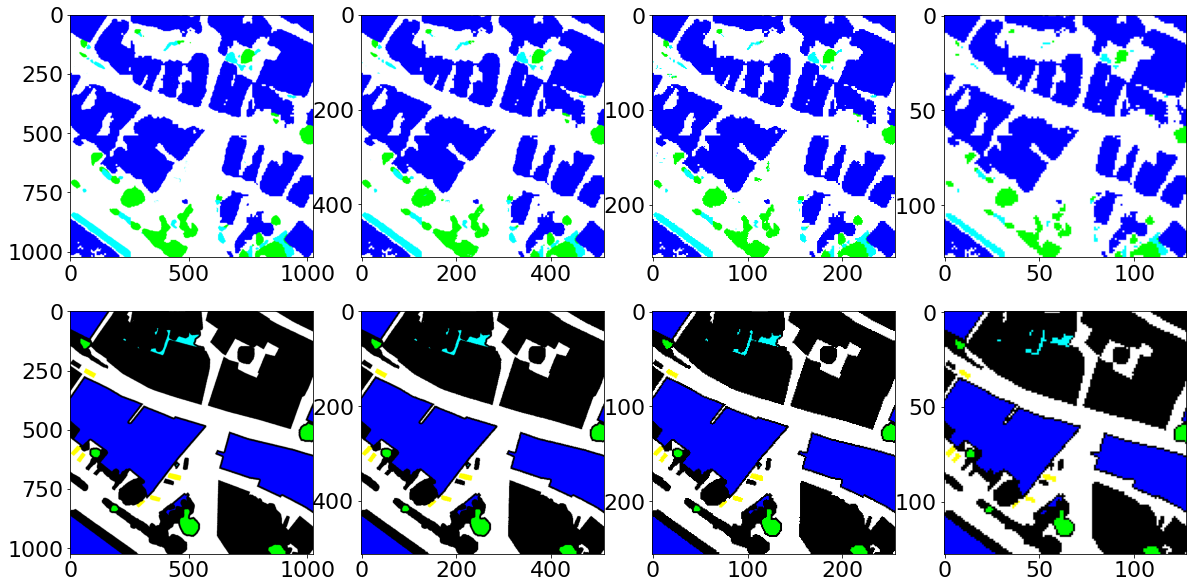

In [53]:
plt.figure(figsize=(20,10))
plt.subplot(241)
plt.imshow(convert_to_color(np.transpose(img_mpm[0], [1,2,0])[:,:,0]))
plt.subplot(242)
plt.imshow(convert_to_color(np.transpose(img_mpm[1], [1,2,0])[:,:,0]))
plt.subplot(243)
plt.imshow(convert_to_color(np.transpose(img_mpm[2], [1,2,0])[:,:,0]))
plt.subplot(244)
plt.imshow(convert_to_color(np.transpose(img_mpm[3], [1,2,0])[:,:,0]))
plt.subplot(245)
plt.imshow(convert_to_color(testQuadTree[0][:,:,0]))
plt.subplot(246)
plt.imshow(convert_to_color(testQuadTree[1][:,:,0]))
plt.subplot(247)
plt.imshow(convert_to_color(testQuadTree[2][:,:,0]))
plt.subplot(248)
plt.imshow(convert_to_color(testQuadTree[3][:,:,0]))
plt.show()

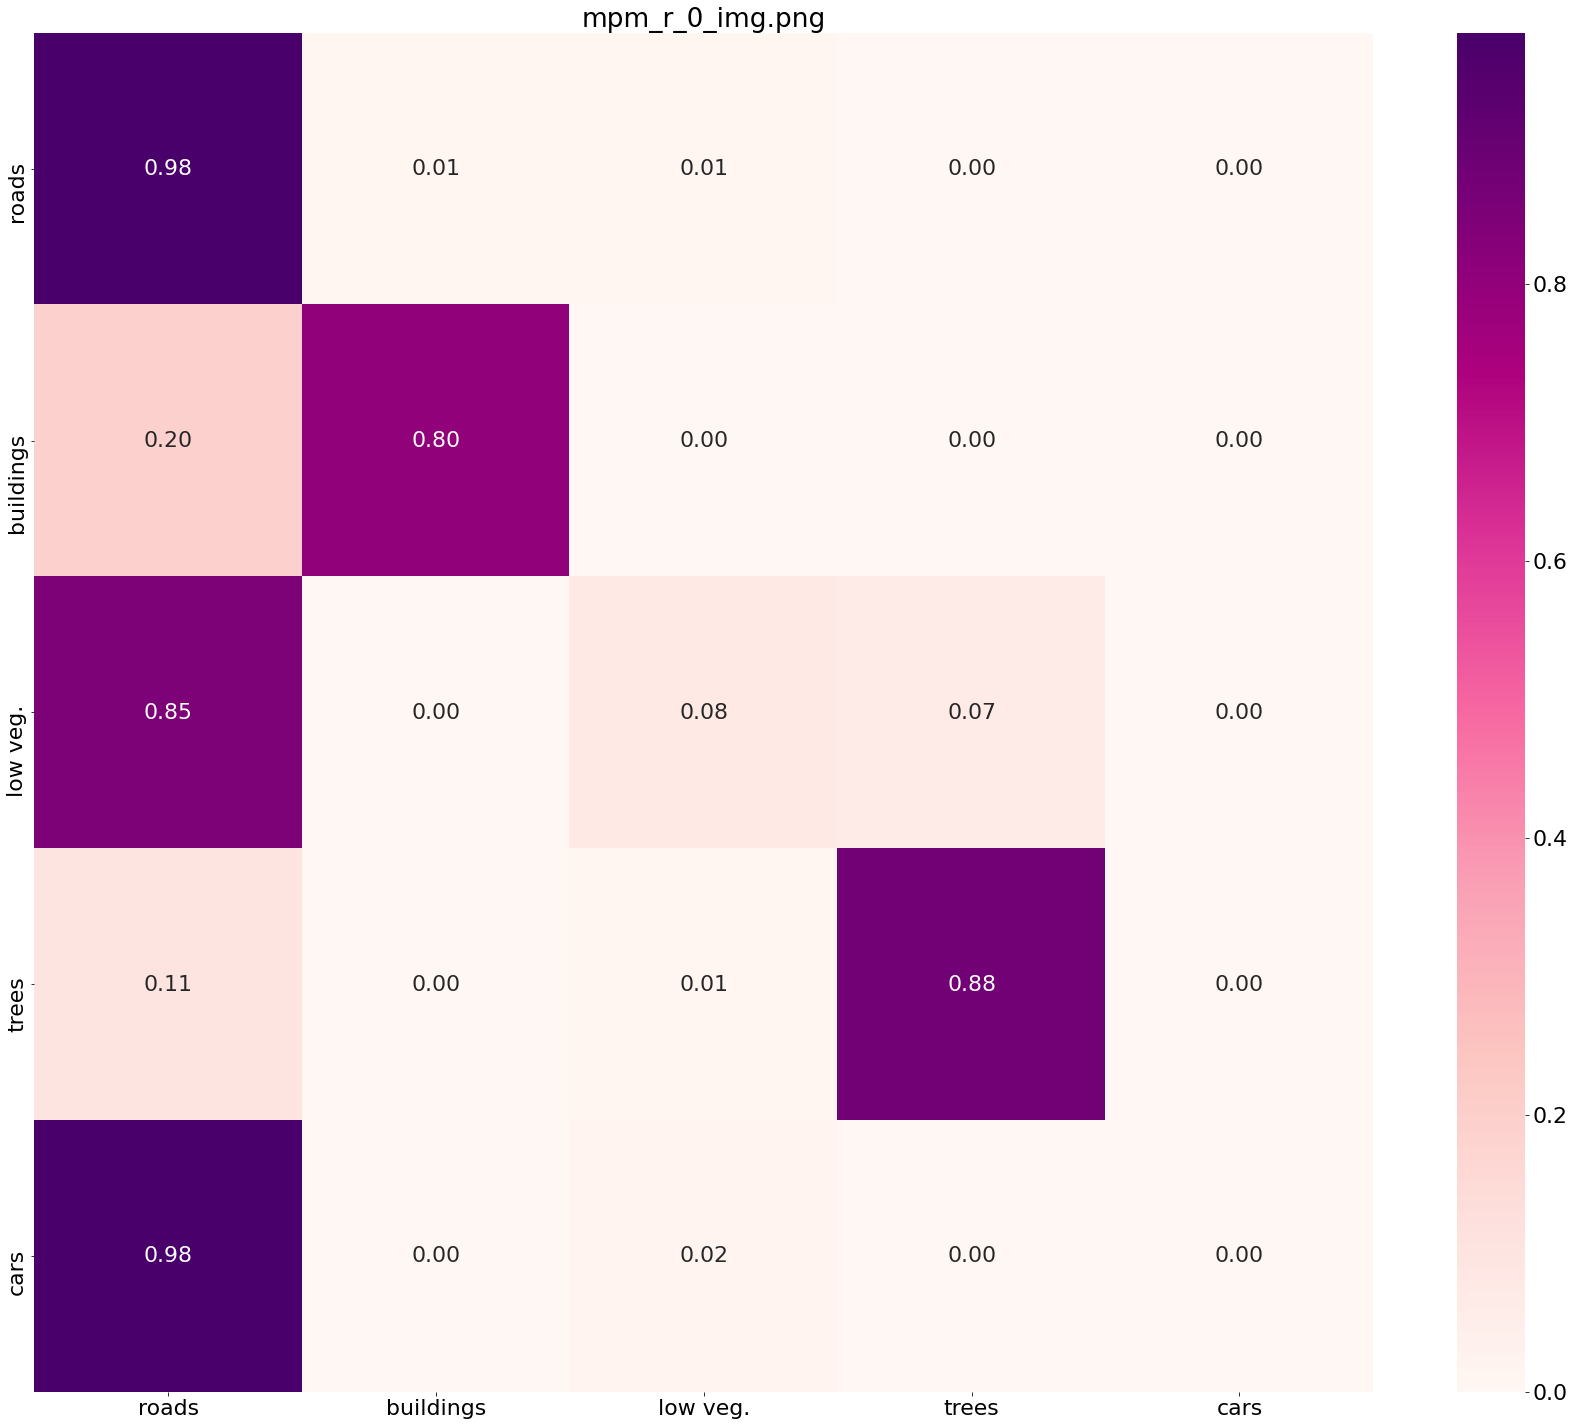

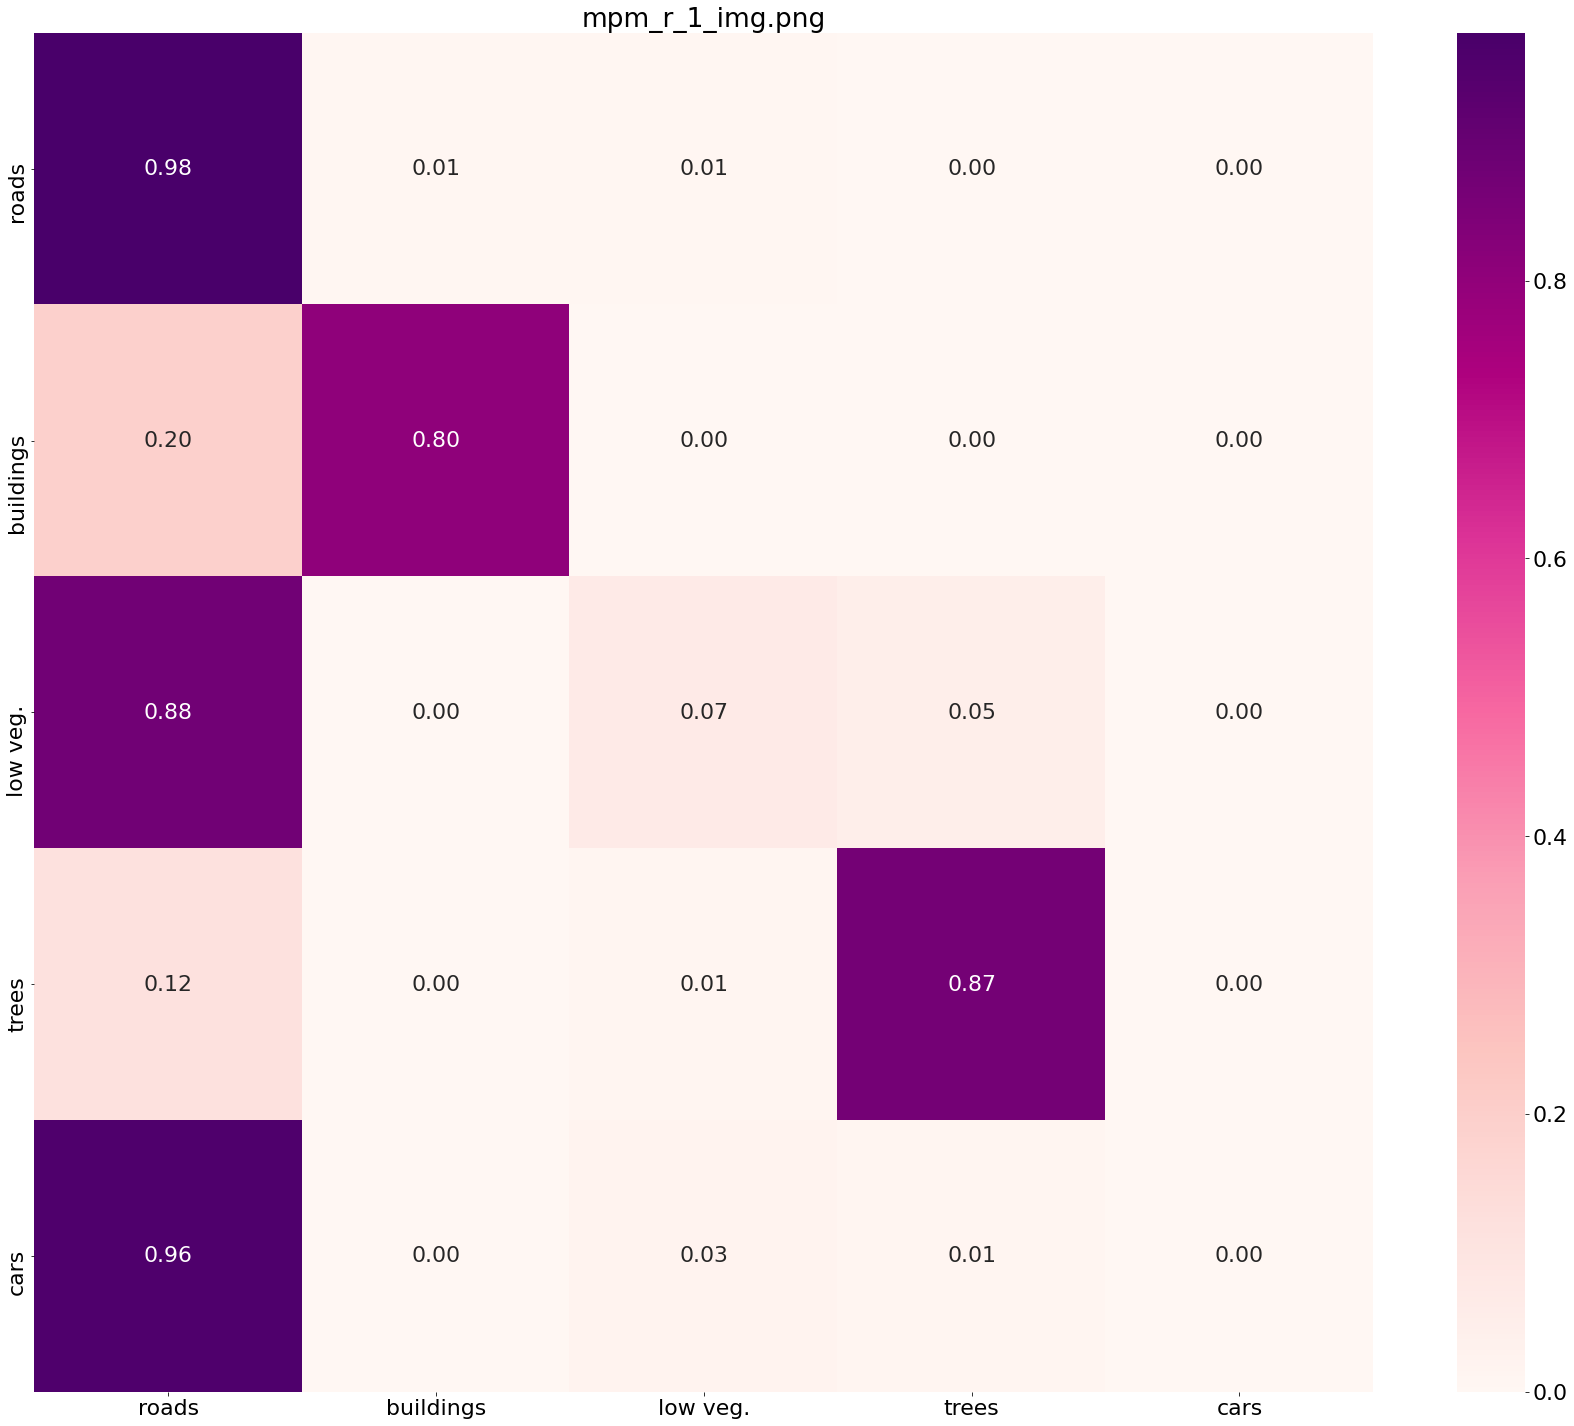

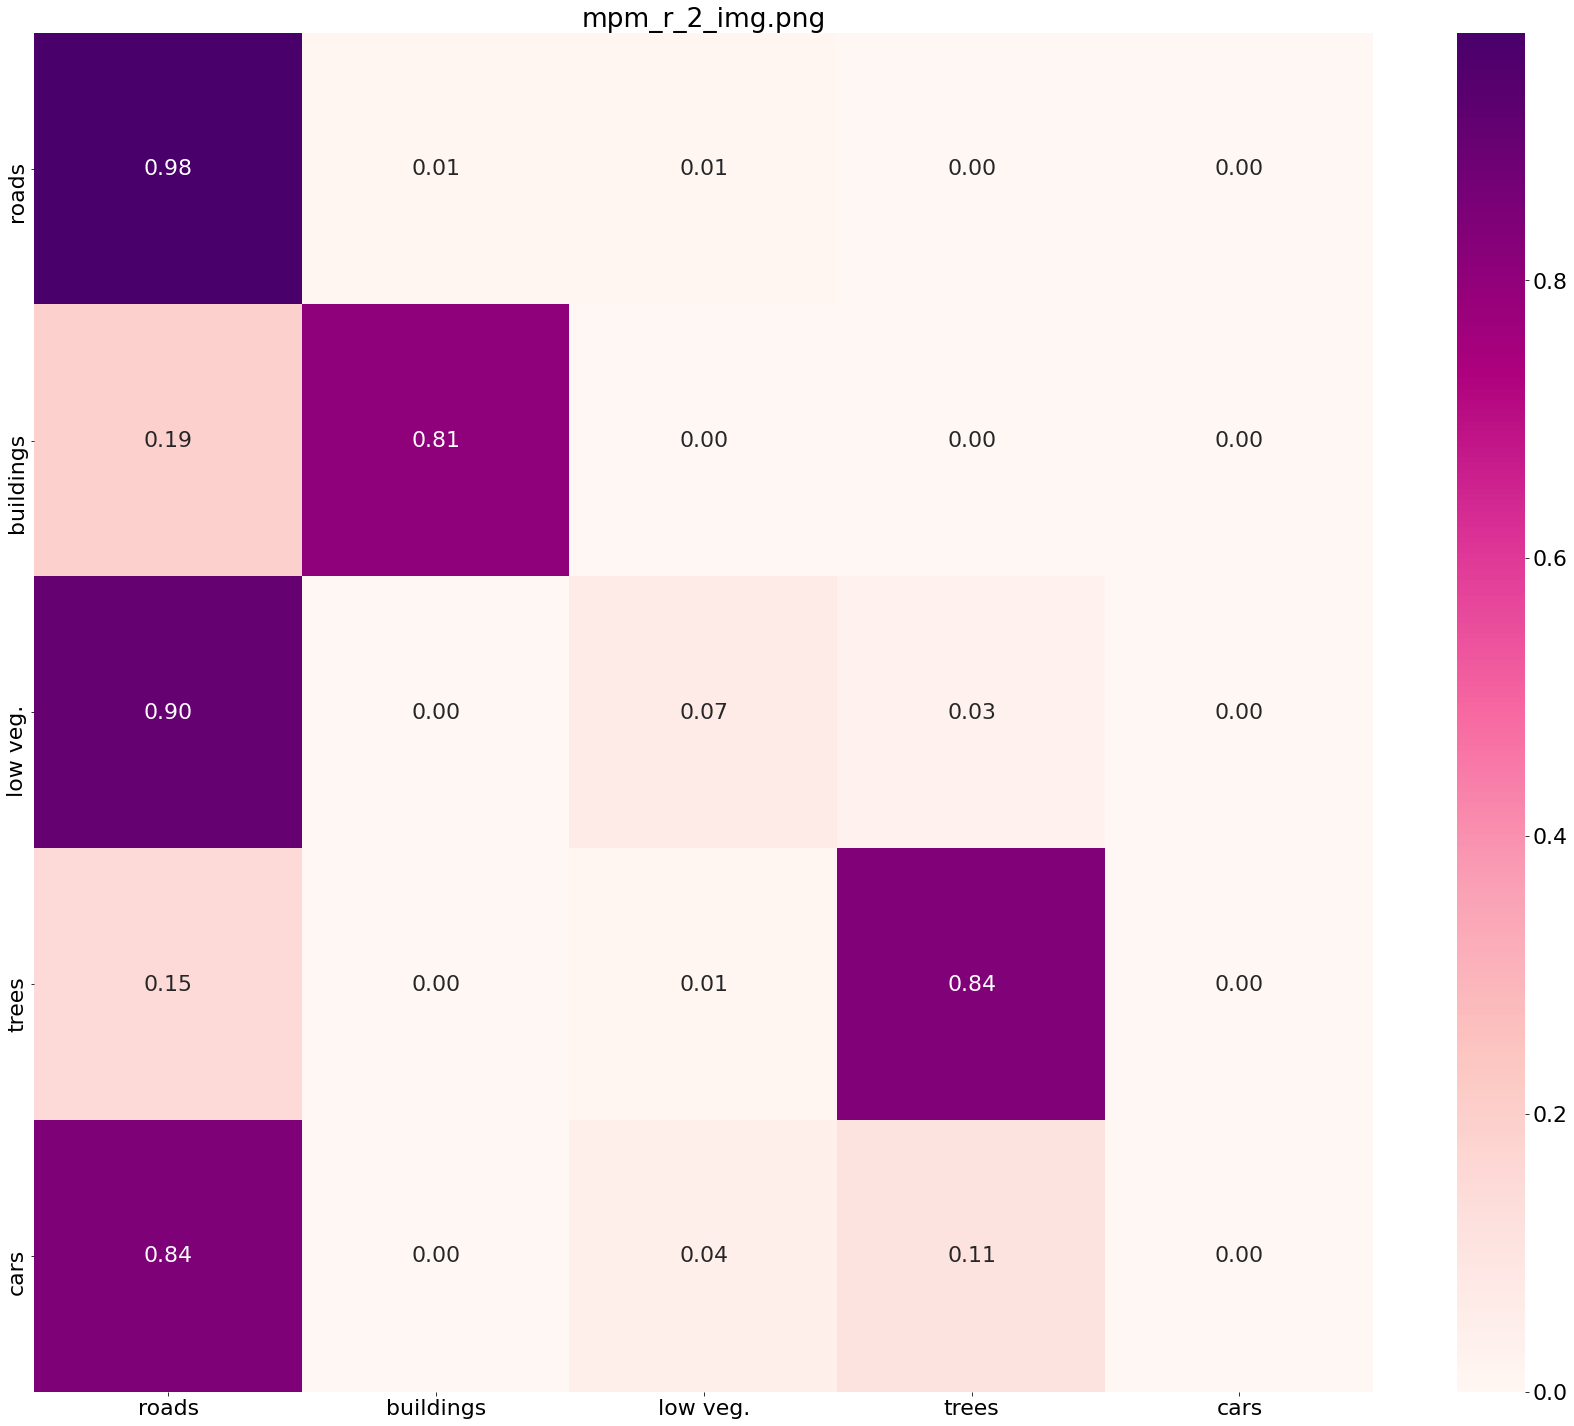

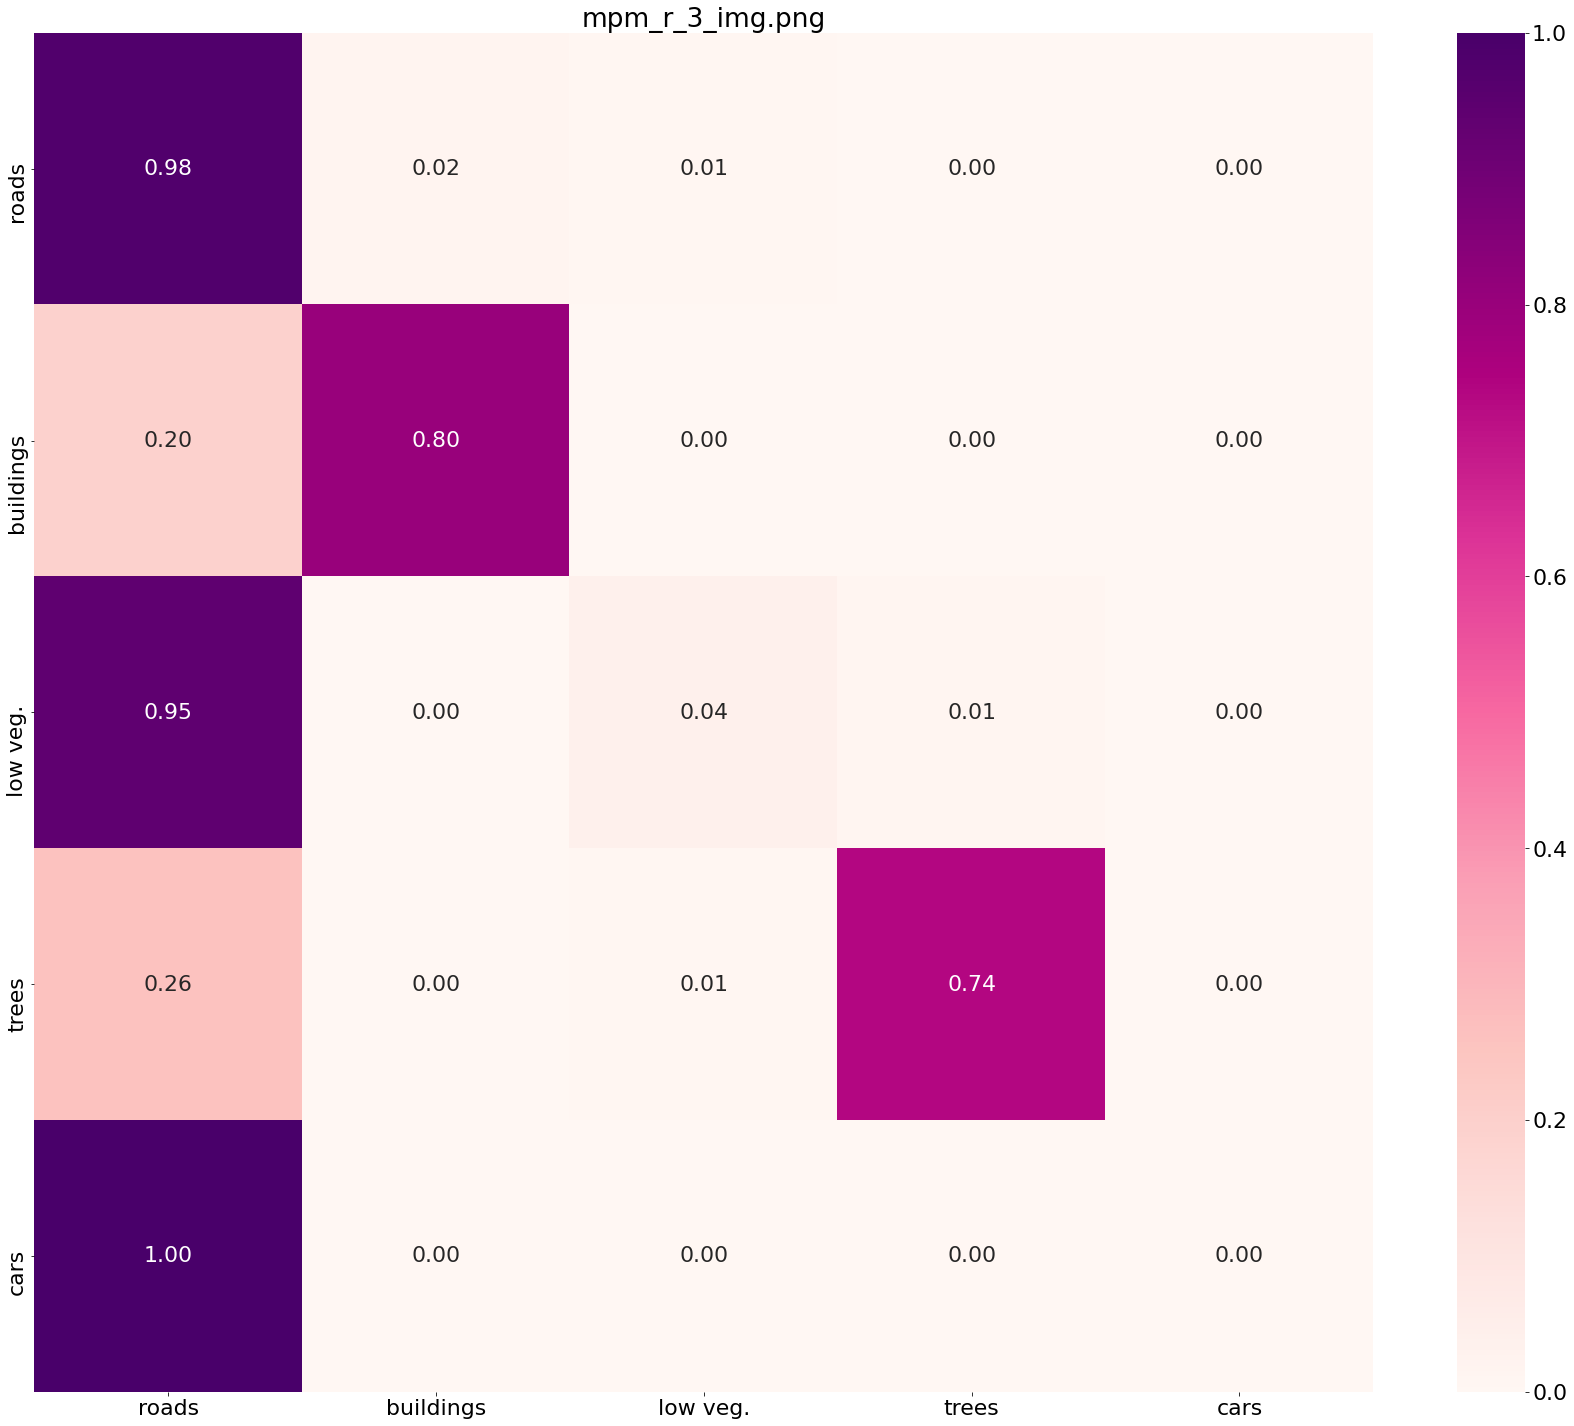

In [51]:
########## save the image and the confusion matrix ##########

for i in range(R):
    mpm_image = convert_to_color(np.transpose(img_mpm[i], [1,2,0])[:,:,0])
    title = 'mpm_r_' + str(i) + '_img.png'
    io.imsave(output_path / title, mpm_image)
    title_cm = "MPM estimation confusion matrix, quadtree level " + str(i)
    name_cm = output_path / str('MPM_r_' + str(i) + '_cm.png')
    print_conf_matr(img_mpm, testQuadTree, i, labels[:-1], title, name_cm)